# Non-stationary flood frequency analysis using the LN2 and LN3 distributions estimated with MOM or MLE

Install lmoments3 and dataretrieval libraries.

In [1]:
!pip install dataretrieval
!pip install lmoments3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.3 MB/s eta 0:00:00


Load utils.py from Google Drive

In [2]:
from google.colab import drive
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# allow access to google drive
drive.mount('/content/drive')

!cp "drive/MyDrive/Colab Notebooks/CE6280/CodingExamples/utils.py" .
from utils import *

Mounted at /content/drive


Consider the time series of annual maxima at Whiteoak Bayou in Houston, TX from water years 1936-2024. This is USGS site [08074500](https://waterdata.usgs.gov/nwis/inventory?site_no=08074500&agency_cd=USGS).

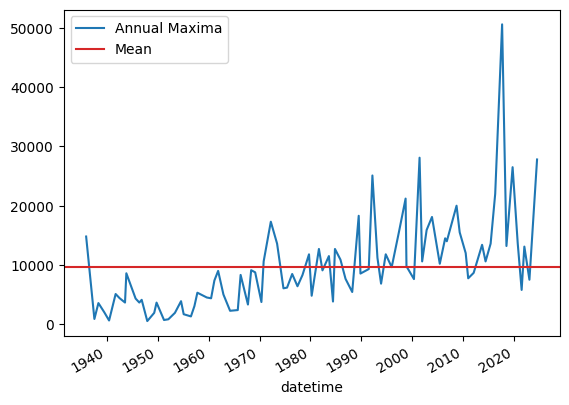

In [3]:
flow_df = nwis.get_record(sites='08074500', service='peaks', start='1935-10-01', end='2024-09-30') # Whiteoak Bayou in Houston, TX
fig, ax = plt.subplots(1,1)
flow_df['peak_va'].plot(ax=ax,label="Annual Maxima")
ax.axhline(np.mean(flow_df['peak_va']),color="tab:red",label="Mean")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels,loc="upper left")

## Stationary flood-frequency analysis

It looks like this time series is non-stationary, so assuming stationarity could lead to underestimation of flood risk. Let's see what that estimated risk would be if we fit LN2 and LN3 distributions to the annual maxima using MOM, MLE, and Lmom assuming stationarity. The code for this is in utils.py.

What would be the estimated return period of the highest observed flood under this assumption?

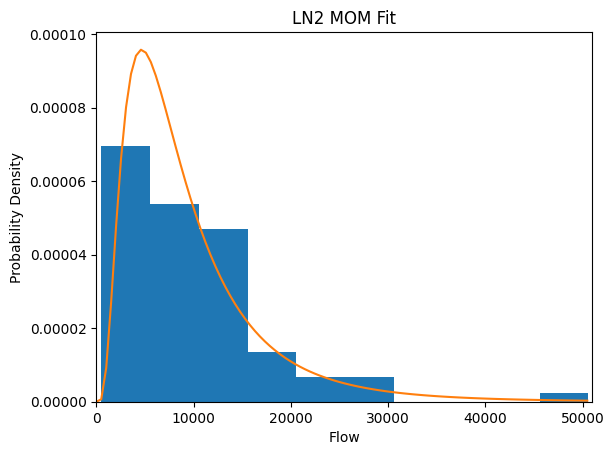

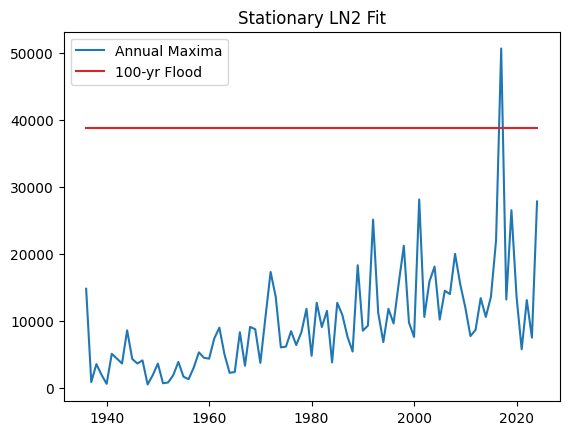

LN2 MOM mu: 8.94
LN2 MOM sigma: 0.70
LN2 MOM tau: 0.00
LN2 MOM 100-yr flood: 38752 cms
Return period of largest flood under LN2 MOM fit: 295 year




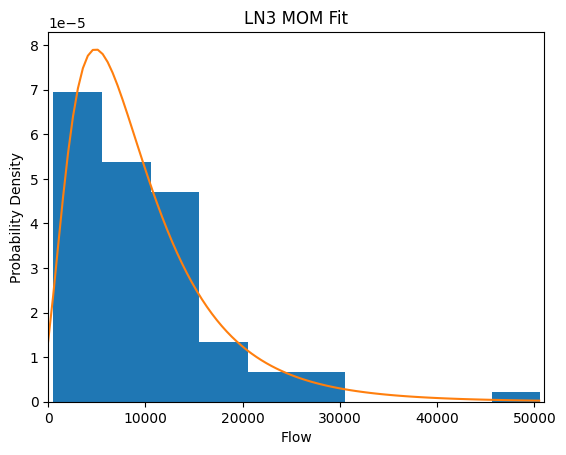

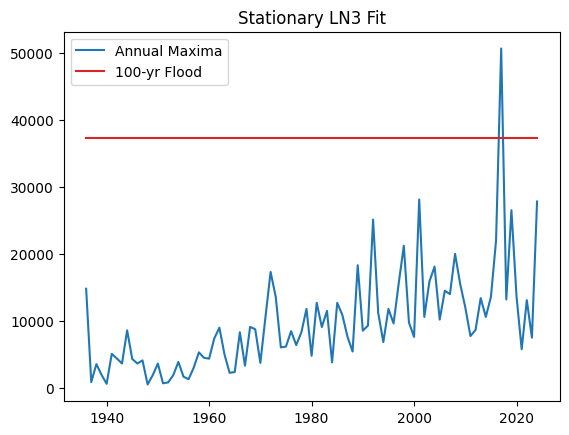

LN3 MOM mu: 9.24
LN3 MOM sigma: 0.58
LN3 MOM tau: -2446.28
LN3 MOM 100-yr flood: 37330 cms
Return period of largest flood under LN3 MOM fit: 417 year




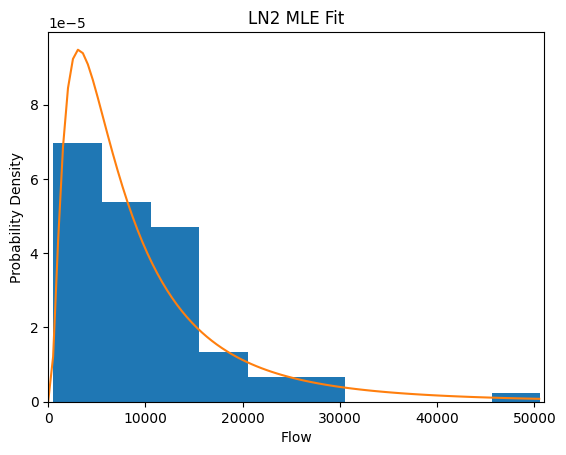

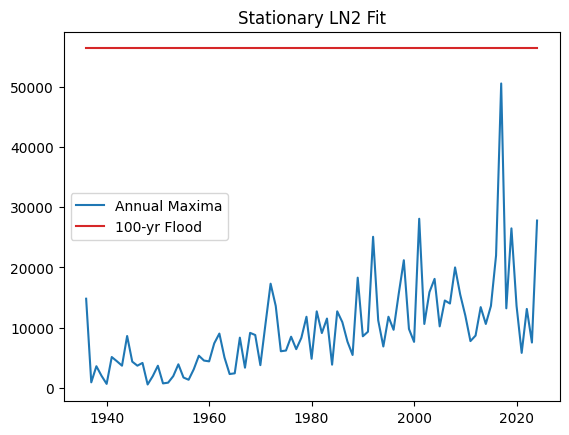

LN2 MLE mu: 8.86
LN2 MLE sigma: 0.90
LN2 MLE tau: 0.00
LN2 MLE 100-yr flood: 56420 cms
Return period of largest flood under LN2 MLE fit: 73 year




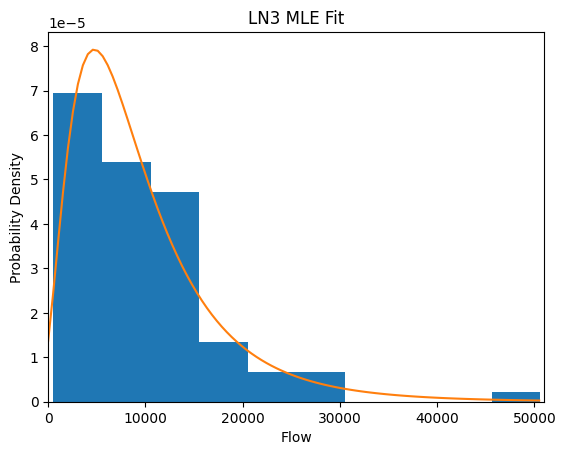

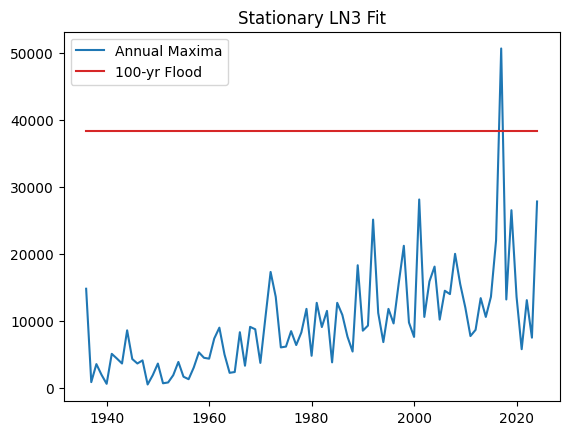

LN3 MLE mu: 9.22
LN3 MLE sigma: 0.60
LN3 MLE tau: -2281.12
LN3 MLE 100-yr flood: 38259 cms
Return period of largest flood under LN3 MLE fit: 356 year




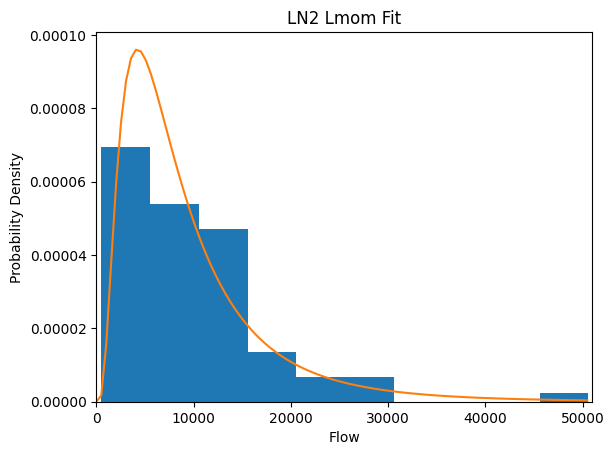

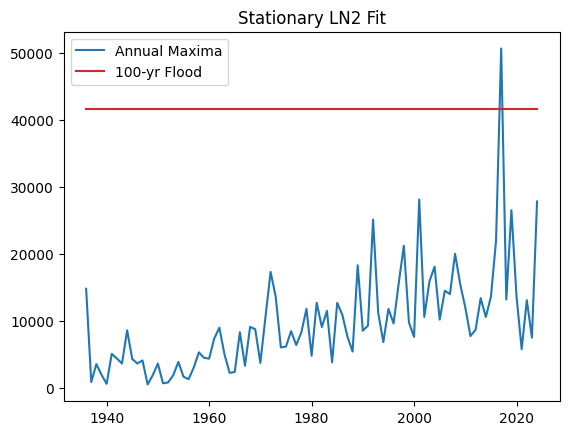

LN2 Lmom mu: 8.90
LN2 Lmom sigma: 0.74
LN2 Lmom tau: 0.00
LN2 Lmom 100-yr flood: 41595 cms
Return period of largest flood under LN2 Lmom fit: 208 year




ValueError: f(a) and f(b) must have different signs

In [4]:
methods = ["MOM", "MLE", "Lmom"]
npars = [2, 3]
flow_df['Year'] = range(1936,2025)

for method in methods:
  for npar in npars:
    distfit = LogNormal()
    distfit.fit(flow_df['peak_va'],method, npar, initialize=False)
    q100 = distfit.findReturnPd(100)
    Tmax = 1/(1 - ss.lognorm.cdf(np.max(flow_df["peak_va"]), distfit.sigma, distfit.tau, np.exp(distfit.mu)))
    distfit.plotHistPDF(flow_df['peak_va'], 0, 51000, "LN" + str(npar) + " " + str(method) + " Fit")
    l1, = plt.plot(flow_df["Year"], flow_df["peak_va"], color='tab:blue')
    l2, = plt.plot(flow_df["Year"], np.ones(len(flow_df["Year"]))*q100, color="tab:red")
    plt.title("Stationary LN" + str(npar) + " Fit")
    plt.legend([l1,l2],['Annual Maxima','100-yr Flood'])
    plt.show()
    print("LN%d %s mu: %0.2f" % (npar, method, distfit.mu))
    print("LN%d %s sigma: %0.2f" % (npar, method, distfit.sigma))
    print("LN%d %s tau: %0.2f" % (npar, method, distfit.tau))
    print("LN%d %s 100-yr flood: %0.0f cms" % (npar, method, q100))
    print("Return period of largest flood under LN%d %s fit: %0.0f year" % (npar, method, Tmax))
    print("\n")

The error when fitting LN3 with L-moments indicates we need to expand the bound in our root finding because the current bounds do not span a root. We would have to change this in utils.py.

Note: there is a better way to find a bracket that will span zero with [scipy.optimize.elementwise.bracket_root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.elementwise.bracket_root.html#scipy.optimize.elementwise.bracket_root) but that function is only available in scipy v1.15. We are using scipy v1.14 because that is the latest version compatible with Python 3.11, which is the default version in Google Colab. Upgrading the Python version in Google Colab is a pain, but if you want to do it on your own machine, it is easier. Example code using scipy.optimize.elementwise.bracket_root within the LogNormal.fit function is shown below if you'd like to do that.

```
from scipy.optimize.elementwise import bracket_root

class LogNormal(Distribution):
  def __init__(self):
    super().__init__()
    self.mu = None
    self.sigma = None
    self.tau = None

  def fit(self, data, method, npars, initialize=True):
    assert method == 'MLE' or method == 'MOM' or method == "Lmom","method must = 'MLE','MOM', or 'Lmom'"
    assert npars == 2 or npars == 3,"npars must = 2 or 3"

    self.findMoments(data)
    self.findLmoments(data)
    if method == 'MLE':
      if initialize == False:
        if npars == 2:
          shape, loc, scale = ss.lognorm.fit(data, floc=0)
        elif npars == 3:
          shape, loc, scale = ss.lognorm.fit(data)
      else:
        if npars == 2:
          self.fit(data, 'Lmom', 2)
          shape, loc, scale = ss.lognorm.fit(data, self.sigma, floc=0)
        elif npars == 3:
          self.fit(data, 'Lmom', 3)
          shape, loc, scale = ss.lognorm.fit(data, self.sigma)

      self.mu = np.log(scale)
      self.sigma = shape
      self.tau = loc
    elif method == 'MOM':
      if npars == 2:
        self.sigma = np.sqrt(np.log(1+self.var/self.xbar**2))
        self.mu = np.log(self.xbar) - 0.5*self.sigma**2
        self.tau = 0
      elif npars == 3:
        bracket = bracket_root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,
                    xl0=0.01)
        self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,
                   bracket.bracket[0], bracket.bracket[1])
        self.mu = 0.5 * (np.log(self.var / (np.exp(self.sigma**2)-1)) - self.sigma**2)
        self.tau = self.xbar - np.exp(self.mu + 0.5*self.sigma**2)
    elif method == 'Lmom':
      if npars == 2:
        self.tau = 0
        self.sigma = root(lambda x: special.erf(x/2) - self.L2/self.L1, 0.01, self.L2)
        self.mu = np.log(self.L1) - 0.5*self.sigma**2
      elif npars == 3:
        bracket = bracket_root(lambda x: self.T3 - (6/np.sqrt(math.pi)) * \
                 integrate.quad(lambda y: special.erf(y/np.sqrt(3))*np.exp(-y**2), 0, x/2)[0] \
                 / math.erf(x/2), xl0=0.01)
        self.sigma = root(lambda x: self.T3 - (6/np.sqrt(math.pi)) * \
                 integrate.quad(lambda y: special.erf(y/np.sqrt(3))*np.exp(-y**2), 0, x/2)[0] \
                 / math.erf(x/2),
                 bracket.bracket[0], bracket.bracket[1])
        self.mu = np.log(self.L2 / math.erf(self.sigma/2)) - 0.5*self.sigma**2
        self.tau = self.L1 - np.exp(self.mu + 0.5*self.sigma**2)
```

## Fitting the above distributions with MOM assuming the mean is linearly changing with time.

First fit a linear trend to the time series of annual maxima, $Y_t$.

$$X_t = \alpha_0 + \alpha_1 t$$

This is the trend in the mean of the LN distributions:

$$E[X_t] = \alpha_0 + \alpha_1 t$$

Note, if you were fitting an LP3 distribution, since we estimate that by fitting a P3 distribution to the log of the data, you would fit a linear trend to the log-transformed time series, $Y_t=\ln(X_t)$.

In [5]:
trend_model = smf.ols(formula="peak_va ~  Year", data=flow_df)
trend_result = trend_model.fit()
print(trend_result.summary())

                            OLS Regression Results                            
Dep. Variable:                peak_va   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     57.11
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           3.90e-11
Time:                        17:45:37   Log-Likelihood:                -900.09
No. Observations:                  89   AIC:                             1804.
Df Residuals:                      87   BIC:                             1809.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -3.63e+05   4.93e+04     -7.359      0.0

Plot the fit.

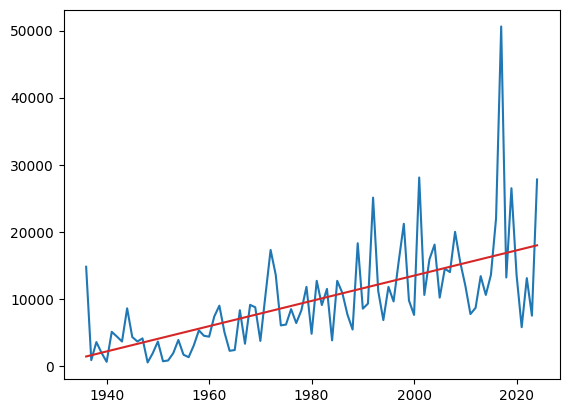

In [6]:
flow_df['trend'] = trend_result.predict()
plt.plot(flow_df['Year'], flow_df['peak_va'], color="tab:blue")
plt.plot(flow_df['Year'], flow_df['trend'], color="tab:red")
plt.show()

Check the diagnostics of this fit.

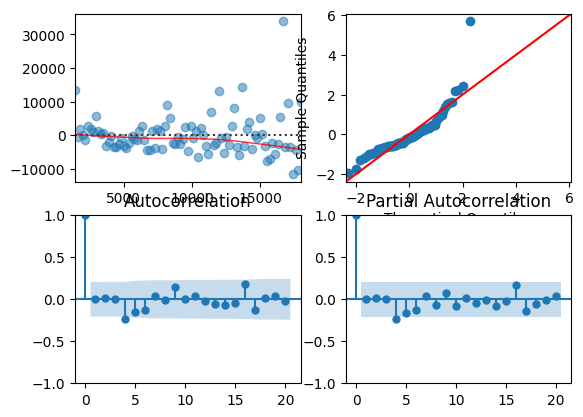

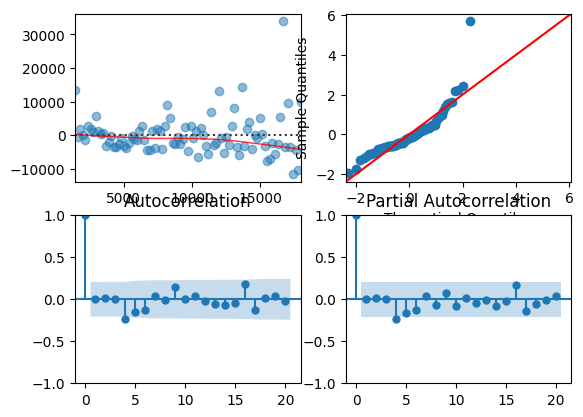

In [7]:
fig ,axes = plt.subplots(2,2)
sns.residplot(x=trend_result.fittedvalues, y=trend_result.resid, lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axes[0,0])
sm.qqplot(trend_result.resid,ss.norm,fit=True,line='45',ax=axes[0,1])
sm.graphics.tsa.plot_acf(trend_result.resid, ax=axes[1,0])
sm.graphics.tsa.plot_pacf(trend_result.resid, ax=axes[1,1])

There does seem to be increasing variance and perhaps non-normality, so let's try fitting the trend to the log of the data.

$$\ln(X_t) = \alpha_0 + \alpha_1 t$$

This equates to the following trend for the mean:

$$E[X_t] = \exp(\alpha_0 + \alpha_1 t)$$

In [8]:
flow_df['log_peak'] = np.log(flow_df['peak_va'])
trend_model = smf.ols(formula="log_peak ~  Year", data=flow_df)
trend_result = trend_model.fit()
print(trend_result.summary())

                            OLS Regression Results                            
Dep. Variable:               log_peak   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     88.78
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           6.14e-15
Time:                        17:45:44   Log-Likelihood:                -85.246
No. Observations:                  89   AIC:                             174.5
Df Residuals:                      87   BIC:                             179.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -40.2374      5.211     -7.722      0.0

Plot the fit.

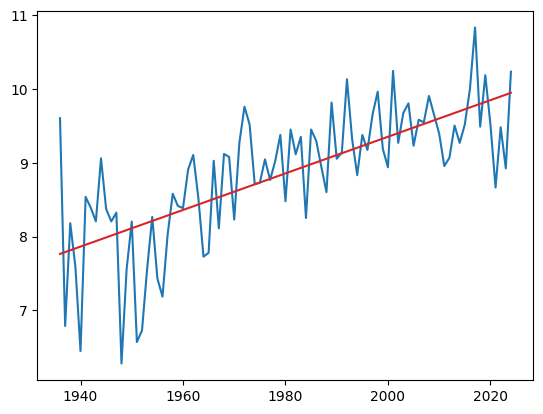

In [9]:
flow_df['log_trend'] = trend_result.predict()
plt.plot(flow_df['Year'], flow_df['log_peak'], color="tab:blue")
plt.plot(flow_df['Year'], flow_df['log_trend'], color="tab:red")
plt.show()

Check the diagnostics of this fit.

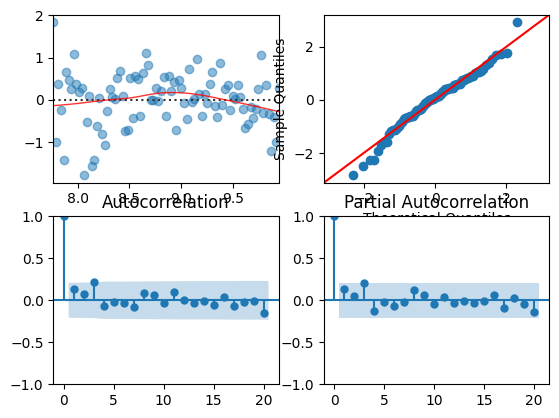

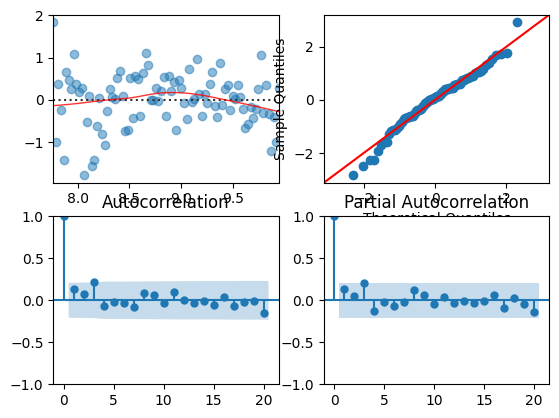

In [10]:
fig ,axes = plt.subplots(2,2)
sns.residplot(x=trend_result.fittedvalues, y=trend_result.resid, lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axes[0,0])
sm.qqplot(trend_result.resid,ss.norm,fit=True,line='45',ax=axes[0,1])
sm.graphics.tsa.plot_acf(trend_result.resid, ax=axes[1,0])
sm.graphics.tsa.plot_pacf(trend_result.resid, ax=axes[1,1])

This looks a lot better! So we'll fit a non-stationary LN2 and LN3 distribution with MOM assuming the log-space mean is changing linearly.

To do this, we need to add a function for non-stationary fitting of the LogNormal distribution, $\texttt{NSfit}$. For now, we'll just include MOM. It will have all the same code as the stationary fit, but we won't be first estimating the moments from the data - we'll run a loop to estimate them at each time step from the linear trend(s).

In [11]:
import math
from scipy.optimize import brentq as root
import scipy.integrate as integrate
import scipy.special as special

class LogNormal(Distribution):
  def __init__(self):
    super().__init__()
    self.mu = None
    self.sigma = None
    self.tau = None

  def fit(self, data, method, npars, initialize=True):
    assert method == 'MLE' or method == 'MOM' or method == "Lmom","method must = 'MLE','MOM', or 'Lmom'"
    assert npars == 2 or npars == 3,"npars must = 2 or 3"

    self.findMoments(data)
    self.findLmoments(data)
    if method == 'MLE':
      if initialize == False:
        if npars == 2:
          shape, loc, scale = ss.lognorm.fit(data, floc=0)
        elif npars == 3:
          shape, loc, scale = ss.lognorm.fit(data)
      else:
        if npars == 2:
          self.fit(data, 'Lmom', 2)
          shape, loc, scale = ss.lognorm.fit(data, self.sigma, floc=0)
        elif npars == 3:
          self.fit(data, 'Lmom', 3)
          shape, loc, scale = ss.lognorm.fit(data, self.sigma)

      self.mu = np.log(scale)
      self.sigma = shape
      self.tau = loc
    elif method == 'MOM':
      if npars == 2:
        self.sigma = np.sqrt(np.log(1+self.var/self.xbar**2))
        self.mu = np.log(self.xbar) - 0.5*self.sigma**2
        self.tau = 0
      elif npars == 3:
        self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,
                   0.01, np.std(np.log(data),ddof=1))
        self.mu = 0.5 * (np.log(self.var / (np.exp(self.sigma**2)-1)) - self.sigma**2)
        self.tau = self.xbar - np.exp(self.mu + 0.5*self.sigma**2)
    elif method == 'Lmom':
      if npars == 2:
        self.tau = 0
        self.sigma = root(lambda x: special.erf(x/2) - self.L2/self.L1, 0.01, self.L2)
        self.mu = np.log(self.L1) - 0.5*self.sigma**2
      elif npars == 3:
        self.sigma = root(lambda x: self.T3 - (6/np.sqrt(math.pi)) * \
                 integrate.quad(lambda y: special.erf(y/np.sqrt(3))*np.exp(-y**2), 0, x/2)[0] \
                 / math.erf(x/2),
                 0.01, 5*self.L2)
        self.mu = np.log(self.L2 / math.erf(self.sigma/2)) - 0.5*self.sigma**2
        self.tau = self.L1 - np.exp(self.mu + 0.5*self.sigma**2)

  def NSfit(self, data, method, npars):
    if method == 'MOM':
      if npars == 2:
        self.sigma = np.sqrt(np.log(1+self.var/self.xbar**2))
        self.mu = np.log(self.xbar) - 0.5*self.sigma**2
        self.tau = 0
      elif npars == 3:
        self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,
                  0.01, 20)
        self.mu = 0.5 * (np.log(self.var / (np.exp(self.sigma**2)-1)) - self.sigma**2)
        self.tau = self.xbar - np.exp(self.mu + 0.5*self.sigma**2)

  def findReturnPd(self, T):
    q_T = ss.lognorm.ppf(1-1/T, self.sigma, self.tau, np.exp(self.mu))
    return q_T

Now let's loop through every time step and re-fit the distribution parameters for the changing mean and estimate the 100-yr flood for each of those time steps based on those parameters.

Return period of largest flood under non-stationary LN2 MOM fit: 312 year


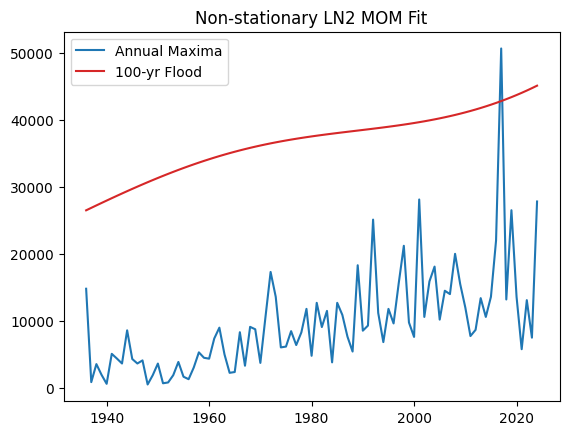

<ipython-input-11-70edb37b6aad>:66: RuntimeWarning: overflow encountered in exp
  self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,


Return period of largest flood under non-stationary LN3 MOM fit: 184 year


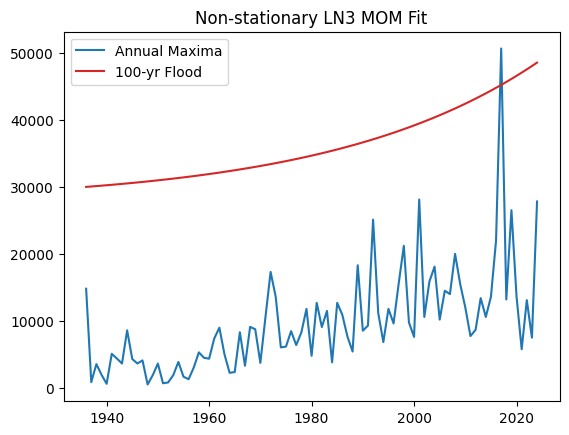

In [12]:
for npar in npars:
  mus = np.empty(len(flow_df["Year"]))
  sigmas = np.empty(len(flow_df["Year"]))
  taus = np.empty(len(flow_df["Year"]))
  q100s = np.empty(len(flow_df["Year"]))
  for i, year in enumerate(flow_df["Year"]):
    distfit = LogNormal()
    # mean estimated from the trend in this year
    distfit.xbar = np.exp(flow_df["log_trend"].iloc[i])

    # variance and skewness from all the data
    distfit.var = np.var(flow_df["peak_va"],ddof=1)
    distfit.skew = ss.skew(flow_df["peak_va"],bias=False)

    # fit the distribution using this year's mean
    distfit.NSfit(flow_df["Year"], 'MOM', npar)

    # record this year's parameter estimates
    mus[i] = distfit.mu
    sigmas[i] = distfit.sigma
    taus[i] = distfit.tau

    # estimated 100-yr flood in this year
    q100s[i] = distfit.findReturnPd(100)

  # estimate the return period of the largest flood in the year it happened
  # based on the non-stationary fit
  index = np.argmax(flow_df["peak_va"])
  Tmax = 1/(1 - ss.lognorm.cdf(np.max(flow_df["peak_va"]), sigmas[index], taus[index], np.exp(mus[index])))
  print("Return period of largest flood under non-stationary LN%d MOM fit: %0.0f year" % (npar, Tmax))

  l1, = plt.plot(flow_df["Year"], flow_df["peak_va"], color='tab:blue')
  l2, = plt.plot(flow_df["Year"], q100s, color="tab:red")
  plt.title("Non-stationary LN" + str(npar) + " MOM Fit")
  plt.legend([l1,l2],['Annual Maxima','100-yr Flood'])
  plt.show()

## Fitting the above distributions with MOM assuming the log-space variance are linearly changing with time.

The variance has to be positive. To ensure this, a common assumption is that its log is changing linearly with time too. Then the following equation can be fit:

$$\ln[{(X_t - E[X_t])^2}] = \beta_0 + \beta_1 t$$

where $X_t$ are the annual maxima and $E[X_t]$ is estimated from the previous regression equation. This equates to the following relationships for the variance and standard deviation:

$$\text{Var}(X_t) = \exp(\beta_0 + \beta_1 t)$$
$$\text{Std}(X_t) = \sqrt{\exp(\beta_0 + \beta_1 t)}$$

Again, note if fitting a P3 distribution to the log of the data for a non-stationary LP3 distribution, you would fit the regression to the log-space variance $\ln[{(Y_t - E[Y_t])^2}]$ where $Y_t=\ln(X_t)$ and $E[Y_t]$ is its mean.

In [13]:
flow_df["log_var"] = np.log((flow_df["peak_va"] - flow_df["trend"])**2)

trend2_model = smf.ols(formula="log_var ~ Year", data=flow_df)
trend2_result = trend2_model.fit()
print(trend2_result.summary())

                            OLS Regression Results                            
Dep. Variable:                log_var   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     13.09
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           0.000498
Time:                        17:45:47   Log-Likelihood:                -197.67
No. Observations:                  89   AIC:                             399.3
Df Residuals:                      87   BIC:                             404.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -51.1220     18.430     -2.774      0.0

Plot the fit.

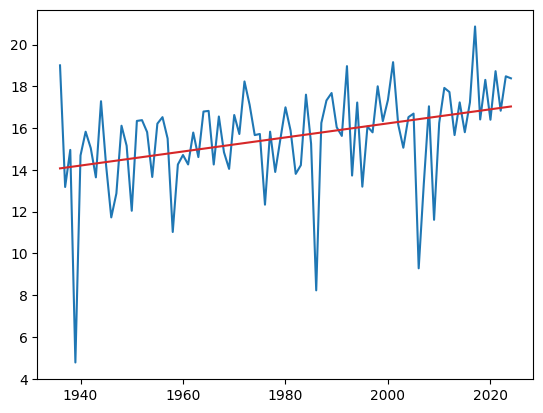

In [14]:
flow_df['logvar_trend'] = trend2_result.predict()
plt.plot(flow_df['Year'], flow_df['log_var'], color="tab:blue")
plt.plot(flow_df['Year'], flow_df['logvar_trend'], color="tab:red")
plt.show()

Check the diagnostics.

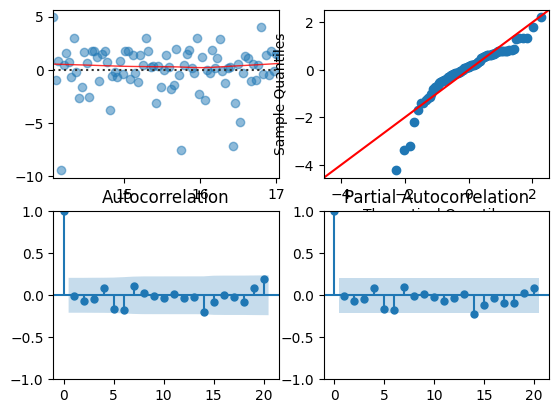

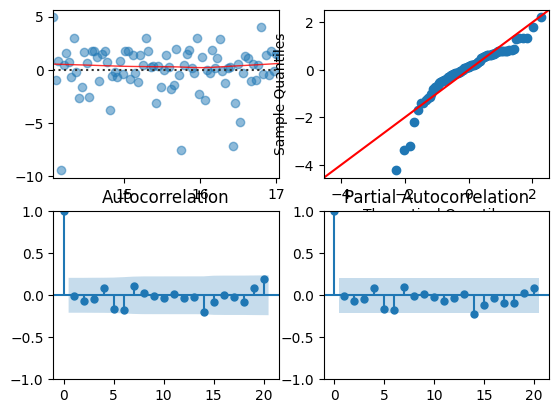

In [15]:
fig, axes = plt.subplots(2,2)
sns.residplot(x=trend2_result.fittedvalues, y=trend2_result.resid, lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axes[0,0])
sm.qqplot(trend2_result.resid,ss.norm,fit=True,line='45',ax=axes[0,1])
sm.graphics.tsa.plot_acf(trend2_result.resid, ax=axes[1,0])
sm.graphics.tsa.plot_pacf(trend2_result.resid, ax=axes[1,1])

The variance of the residuals is relatively constant, and they are independent, but they are not normal. **For this reason, we should probably not proceed with this fit in practice, but find another transformation**, but we will illustrate the process below as an example.

To do this, we'll loop through every time step and re-fit the distribution parameters for the changing mean **and variance** and estimate the 100-yr flood for each of those time steps based on those parameters.

Return period of largest flood under non-stationary LN2 MOM fit: 164320 year


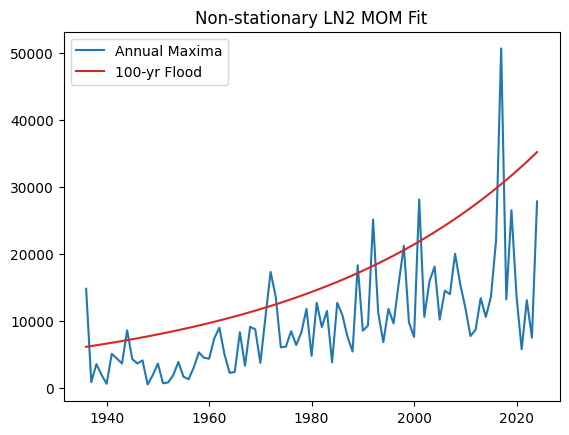

<ipython-input-11-70edb37b6aad>:66: RuntimeWarning: overflow encountered in exp
  self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,


Return period of largest flood under non-stationary LN3 MOM fit: 1982 year


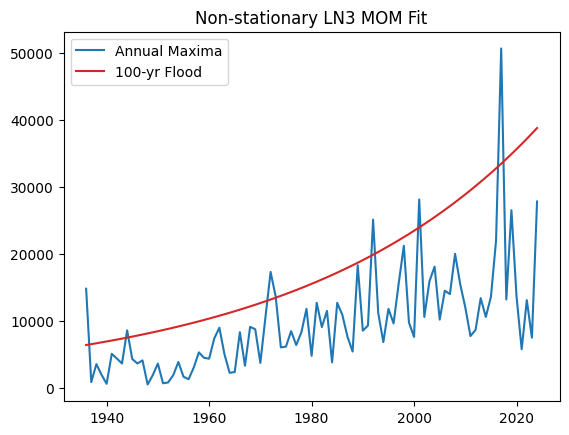

In [16]:
for npar in npars:
  mus = np.empty(len(flow_df["Year"]))
  sigmas = np.empty(len(flow_df["Year"]))
  taus = np.empty(len(flow_df["Year"]))
  q100s = np.empty(len(flow_df["Year"]))
  for i, year in enumerate(flow_df["Year"]):
    distfit = LogNormal()
    # mean and variance estimated from the trend in this year
    distfit.xbar = np.exp(flow_df["log_trend"].iloc[i])
    distfit.var = np.exp(flow_df["logvar_trend"].iloc[i])

    # skewness from all the data
    distfit.skew = ss.skew(flow_df["peak_va"],bias=False)

    # fit the distribution using this year's mean and variance
    distfit.NSfit(flow_df["Year"], 'MOM', npar)

    # record this year's parameter estimates
    mus[i] = distfit.mu
    sigmas[i] = distfit.sigma
    taus[i] = distfit.tau

    # estimated 100-yr flood in this year
    q100s[i] = distfit.findReturnPd(100)

  # estimate the return period of the largest flood in the year it happened
  # based on the non-stationary fit
  index = np.argmax(flow_df["peak_va"])
  Tmax = 1/(1 - ss.lognorm.cdf(np.max(flow_df["peak_va"]), sigmas[index], taus[index], np.exp(mus[index])))
  print("Return period of largest flood under non-stationary LN%d MOM fit: %0.0f year" % (npar, Tmax))

  l1, = plt.plot(flow_df["Year"], flow_df["peak_va"], color='tab:blue')
  l2, = plt.plot(flow_df["Year"], q100s, color="tab:red")
  plt.title("Non-stationary LN" + str(npar) + " MOM Fit")
  plt.legend([l1,l2],['Annual Maxima','100-yr Flood'])
  plt.show()

These fits don't seem reasonable, as the 100-yr flood estimate is exceeded several times in 89 years. This is perhaps not surprising given the issues with the diagnostics of the fitted trend in the log of the variance.

## Fitting LN3 distributions with MOM assuming the mean, variance, and skewness are changing linearly with time.

If the coefficient of skewness is changing linearly with time too, the following equation can be fit:

$$[(X_t - E[X_t])/\text{Std}(X_t)]^3 = \gamma_0 + \gamma_1 t$$

where $X_t$ are the annual maxima and $E[X_t]$ and $\text{Std}(X_t)$ are estimated from the previous regression equations.

Again, note if fitting a P3 distribution to the log of the data for a non-stationary LP3 distribution, you would fit the above regression to the log-space variance $[(Y_t - E[Y_t])/\text{Std}(Y_t)]^3$ where $Y_t=\ln(X_t)$ and $E[Y_t]$ and $\text{Std}(Y_t)$ are its mean and standard deviation.

In [17]:
flow_df["std_trend"] = np.sqrt(np.exp(flow_df["logvar_trend"]))
flow_df["skew"] = ((flow_df["peak_va"] - flow_df["trend"])/flow_df["std_trend"])**3

trend3_model = smf.ols(formula="skew ~ Year", data=flow_df)
trend3_result = trend3_model.fit()
print(trend3_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   skew   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.616
Date:                Fri, 14 Mar 2025   Prob (F-statistic):              0.207
Time:                        17:45:49   Log-Likelihood:                -586.94
No. Observations:                  89   AIC:                             1178.
Df Residuals:                      87   BIC:                             1183.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1884.4090   1462.350      1.289      0.2

**Note, this is not statistically significant, so we probably should not do this**, but we'll show the approach as an example.

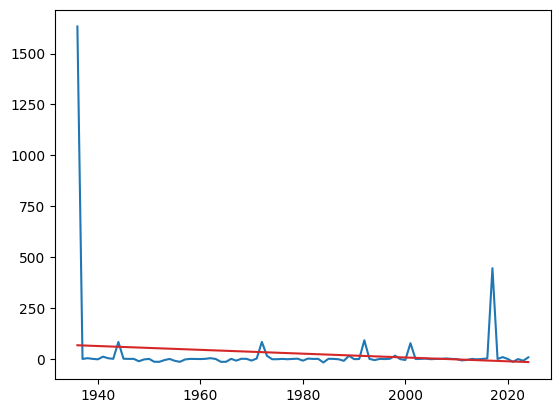

In [18]:
flow_df['skew_trend'] = trend3_result.predict()
plt.plot(flow_df['Year'], flow_df['skew'], color="tab:blue")
plt.plot(flow_df['Year'], flow_df['skew_trend'], color="tab:red")
plt.show()

Check the diagnostics.

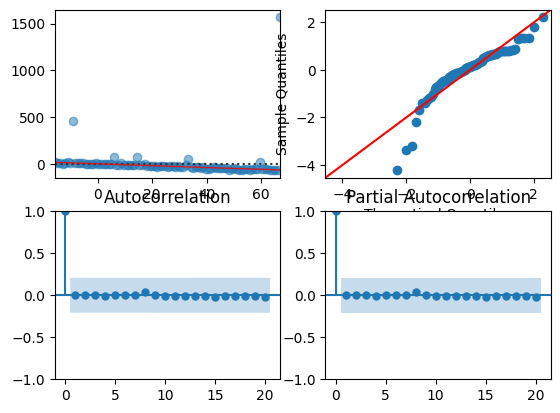

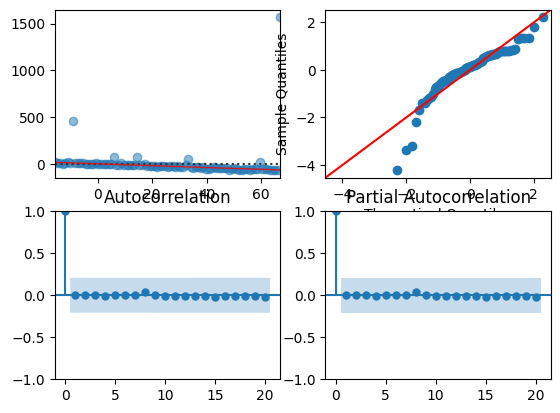

In [19]:
fig, axes = plt.subplots(2,2)
sns.residplot(x=trend3_result.fittedvalues, y=trend3_result.resid, lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axes[0,0])
sm.qqplot(trend2_result.resid,ss.norm,fit=True,line='45',ax=axes[0,1])
sm.graphics.tsa.plot_acf(trend3_result.resid, ax=axes[1,0])
sm.graphics.tsa.plot_pacf(trend3_result.resid, ax=axes[1,1])

Not surprisingly, **the diagnostics on this trend are also poor, further reinforcing that we should not do this!** But we show how to as an example below.

To do this, we'll loop through every time step and re-fit the distribution parameters for the changing mean, variance, **and skew** and estimate the 100-yr flood for each of those time steps based on those parameters.

Return period of largest flood under non-stationary LN2 MOM fit: 164320 year


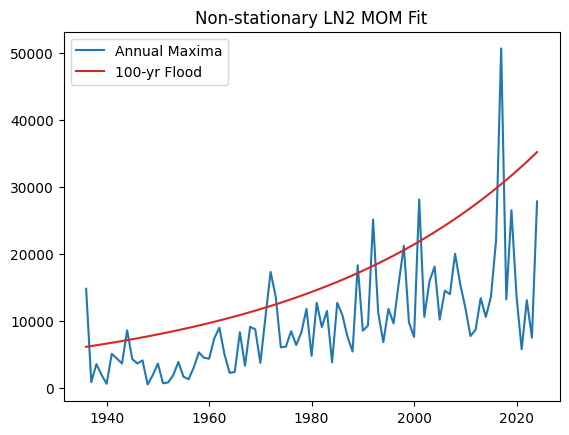

<ipython-input-11-70edb37b6aad>:66: RuntimeWarning: overflow encountered in exp
  self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,


ValueError: f(a) and f(b) must have different signs

In [20]:
for npar in npars:
  mus = np.empty(len(flow_df["Year"]))
  sigmas = np.empty(len(flow_df["Year"]))
  taus = np.empty(len(flow_df["Year"]))
  q100s = np.empty(len(flow_df["Year"]))
  for i, year in enumerate(flow_df["Year"]):
    distfit = LogNormal()
    # mean, variance and skewness estimated from the trend in this year
    distfit.xbar = np.exp(flow_df["log_trend"].iloc[i])
    distfit.var = np.exp(flow_df["logvar_trend"].iloc[i])
    distfit.skew = flow_df["skew_trend"].iloc[i]

    # fit the distribution using this year's mean and variance
    distfit.NSfit(flow_df["Year"], 'MOM', npar)

    # record this year's parameter estimates
    mus[i] = distfit.mu
    sigmas[i] = distfit.sigma
    taus[i] = distfit.tau

    # estimated 100-yr flood in this year
    q100s[i] = distfit.findReturnPd(100)

  # estimate the return period of the largest flood in the year it happened
  # based on the non-stationary fit
  index = np.argmax(flow_df["peak_va"])
  Tmax = 1/(1 - ss.lognorm.cdf(np.max(flow_df["peak_va"]), sigmas[index], taus[index], np.exp(mus[index])))
  print("Return period of largest flood under non-stationary LN%d MOM fit: %0.0f year" % (npar, Tmax))

  l1, = plt.plot(flow_df["Year"], flow_df["peak_va"], color='tab:blue')
  l2, = plt.plot(flow_df["Year"], q100s, color="tab:red")
  plt.title("Non-stationary LN" + str(npar) + " MOM Fit")
  plt.legend([l1,l2],['Annual Maxima','100-yr Flood'])
  plt.show()

The LN2 fit again seems unreasonable given the frequent exceedance of the 100-yr flood estimate over the 89-year record.

The LN3 estimation gets a sign error with the root function, indicating we would have to widen our bounds, although we then risk an overflow in the exponential. Given the poor fits in the trends, this does not seem worth playing around with.

## Fitting the above distributions with MLE assuming non-stationarity in 1, 2, or 3 of the parameters.

To do this, we need to write the log-likelihood function as the sum of the log(pdf) evaluated at data point $i$ using the parameter values at time step $i$. This will depend on how many parameters are assumed to be linearly changing with time, so we need separate cases defining the log-likelihood depending on how many parameters are non-stationary.

Then we estimate those parameters using optimization to find which values maximize the log-likelihood. We can use [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), which requires to inputs: a function that takes in decision variables (x) and returns an objective to be minimizes, and initial estimates of x. We'll return the negated log-likelihood since minimizing that is equivalent to maximizing the likelihood. We'll initialize the parameter estimates at their stationary values (so assuming 0 slope and an intercept at the stationary value).

In [21]:
from scipy.optimize import minimize

class LogNormal(Distribution):
  def __init__(self):
    super().__init__()
    self.mu = None
    self.sigma = None
    self.tau = None

  def fit(self, data, method, npars, initialize=True):
    assert method == 'MLE' or method == 'MOM' or method == "Lmom","method must = 'MLE','MOM', or 'Lmom'"
    assert npars == 2 or npars == 3,"npars must = 2 or 3"

    self.findMoments(data)
    self.findLmoments(data)
    if method == 'MLE':
      if initialize == False:
        if npars == 2:
          shape, loc, scale = ss.lognorm.fit(data, floc=0)
        elif npars == 3:
          shape, loc, scale = ss.lognorm.fit(data)
      else:
        if npars == 2:
          self.fit(data, 'Lmom', 2)
          shape, loc, scale = ss.lognorm.fit(data, self.sigma, floc=0)
        elif npars == 3:
          self.fit(data, 'Lmom', 3)
          shape, loc, scale = ss.lognorm.fit(data, self.sigma)

      self.mu = np.log(scale)
      self.sigma = shape
      self.tau = loc
    elif method == 'MOM':
      if npars == 2:
        self.sigma = np.sqrt(np.log(1+self.var/self.xbar**2))
        self.mu = np.log(self.xbar) - 0.5*self.sigma**2
        self.tau = 0
      elif npars == 3:
        self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,
                   0.01, np.std(np.log(data),ddof=1))
        self.mu = 0.5 * (np.log(self.var / (np.exp(self.sigma**2)-1)) - self.sigma**2)
        self.tau = self.xbar - np.exp(self.mu + 0.5*self.sigma**2)
    elif method == 'Lmom':
      if npars == 2:
        self.tau = 0
        self.sigma = root(lambda x: special.erf(x/2) - self.L2/self.L1, 0.01, self.L2)
        self.mu = np.log(self.L1) - 0.5*self.sigma**2
      elif npars == 3:
        self.sigma = root(lambda x: self.T3 - (6/np.sqrt(math.pi)) * \
                 integrate.quad(lambda y: special.erf(y/np.sqrt(3))*np.exp(-y**2), 0, x/2)[0] \
                 / math.erf(x/2),
                 0.01, 5*self.L2)
        self.mu = np.log(self.L2 / math.erf(self.sigma/2)) - 0.5*self.sigma**2
        self.tau = self.L1 - np.exp(self.mu + 0.5*self.sigma**2)

  def NSfit(self, data, method, npars, nNSpars):
    if method == 'MOM':
      if npars == 2:
        self.sigma = np.sqrt(np.log(1+self.var/self.xbar**2))
        self.mu = np.log(self.xbar) - 0.5*self.sigma**2
        self.tau = 0
      elif npars == 3:
        self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,
                  0.01, 20)
        self.mu = 0.5 * (np.log(self.var / (np.exp(self.sigma**2)-1)) - self.sigma**2)
        self.tau = self.xbar - np.exp(self.mu + 0.5*self.sigma**2)
    elif method == "MLE":
      if npars == 2:
        # get initial parameter estimates
        shape, loc, scale = ss.lognorm.fit(data, floc=0)
        if nNSpars == 1:
          x0 = [shape, scale, 0]
          def logLik(x):
            logLik = 0
            for i in range(len(data)):
              logLik += ss.lognorm.logpdf(data[i], x[0], 0, x[1] + x[2]*i)
            return -logLik
          result = minimize(logLik, x0)
          self.sigma = result.x[0]
          self.tau = 0
          self.mu = np.log(result.x[1] + result.x[2]*np.arange(len(data)))
        elif nNSpars == 2:
          x0 = [shape, 0, scale, 0]
          def logLik(x):
            logLik = 0
            for i in range(len(data)):
              logLik += ss.lognorm.logpdf(data[i], x[0] + x[1]*i, 0, x[2] + x[3]*i)
            return -logLik
          # add constraints that shape parameter has to be positive at every time step
          constraints = []
          for i in range(len(data)):
            constraints.append({'type': 'ineq', 'fun': lambda x: x[0] + x[1]*i})
          result = minimize(logLik, x0, constraints=constraints)
          self.sigma = result.x[0] + result.x[1]*np.arange(len(data))
          self.tau = 0
          self.mu = np.log(result.x[2] + result.x[3]*np.arange(len(data)))
      elif npars == 3:
        # get initial parameter estimates
        shape, loc, scale = ss.lognorm.fit(data)
        if nNSpars == 1:
          x0 = [shape, loc, scale, 0]
          def logLik(x):
            logLik = 0
            for i in range(len(data)):
              logLik += ss.lognorm.logpdf(data[i], x[0], x[1], x[2] + x[3]*i)
            return -logLik
          result = minimize(logLik, x0)
          self.sigma = result.x[0]
          self.tau = result.x[1]
          self.mu = np.log(result.x[2] + result.x[3]*np.arange(len(data)))
        elif nNSpars == 2:
          x0 = [shape, 0, loc, scale, 0]
          def logLik(x):
            logLik = 0
            for i in range(len(data)):
              logLik += ss.lognorm.logpdf(data[i], x[0] + x[1]*i, x[2], x[3] + x[4]*i)
            return -logLik
          # add constraints that shape parameter has to be positive at every time step
          constraints = []
          for i in range(len(data)):
            constraints.append({'type': 'ineq', 'fun': lambda x: x[0] + x[1]*i})
          result = minimize(logLik, x0, constraints=constraints)
          self.sigma = result.x[0] + result.x[1]*np.arange(len(data))
          self.tau = result.x[2]
          self.mu = np.log(result.x[3] + result.x[4]*np.arange(len(data)))
        elif nNSpars == 3:
          x0 = [shape, 0, loc, 0, scale, 0]
          def logLik(x):
            logLik = 0
            for i in range(len(data)):
              logLik += ss.lognorm.logpdf(data[i], x[0] + x[1]*i, x[2] + x[3]*i, x[4] + x[5]*i)
            return -logLik
          # add constraints that shape parameter has to be positive at every time step
          constraints = []
          for i in range(len(data)):
            constraints.append({'type': 'ineq', 'fun': lambda x: x[0] + x[1]*i})
          result = minimize(logLik, x0, constraints=constraints)
          self.sigma = result.x[0] + result.x[1]*np.arange(len(data))
          self.tau = result.x[2] + result.x[3]*np.arange(len(data))
          self.mu = np.log(result.x[4] + result.x[5]*np.arange(len(data)))

  def findReturnPd(self, T):
    q_T = ss.lognorm.ppf(1-1/T, self.sigma, self.tau, np.exp(self.mu))
    return q_T

## First let's assume only the scale parameter is linearly changing with time.

Return period of largest flood under non-stationary LN2 MLE fit: 51 year


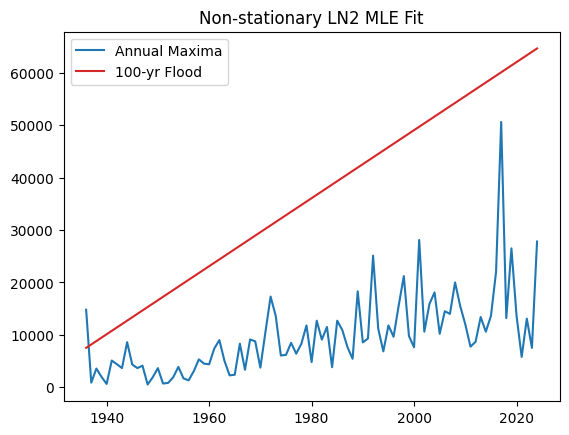

Return period of largest flood under non-stationary LN3 MLE fit: 378 year


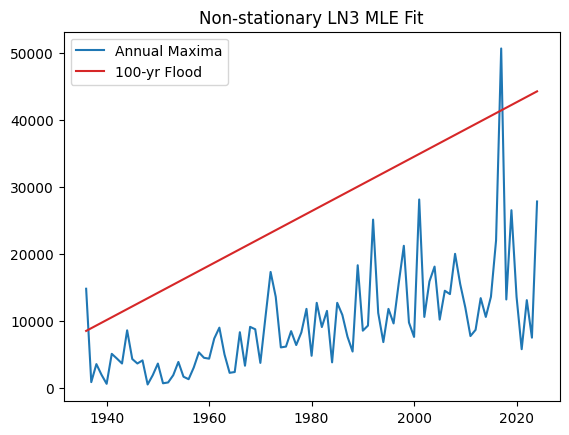

In [22]:
for npar in npars:
  distfit = LogNormal()
  distfit.NSfit(np.array(flow_df["peak_va"]), "MLE", npar, 1)
  mus = distfit.mu

  # estimate 100-yr flood each year
  q100s = np.empty(len(flow_df["Year"]))
  for i, year in enumerate(flow_df["Year"]):
    distfit.mu = mus[i]
    q100s[i] = distfit.findReturnPd(100)

  # estimate the return period of the largest flood in the year it happened
  # based on the non-stationary fit
  index = np.argmax(flow_df["peak_va"])
  Tmax = 1/(1 - ss.lognorm.cdf(np.max(flow_df["peak_va"]), distfit.sigma, distfit.tau, np.exp(mus[index])))
  print("Return period of largest flood under non-stationary LN%d MLE fit: %0.0f year" % (npar, Tmax))

  l1, = plt.plot(flow_df["Year"], flow_df["peak_va"], color='tab:blue')
  l2, = plt.plot(flow_df["Year"], q100s, color="tab:red")
  plt.title("Non-stationary LN" + str(npar) + " MLE Fit")
  plt.legend([l1,l2],['Annual Maxima','100-yr Flood'])
  plt.show()

## Now assume the scale and shape parameters are linearly changing with time.

Return period of largest flood under non-stationary LN2 MLE fit: 1082 year


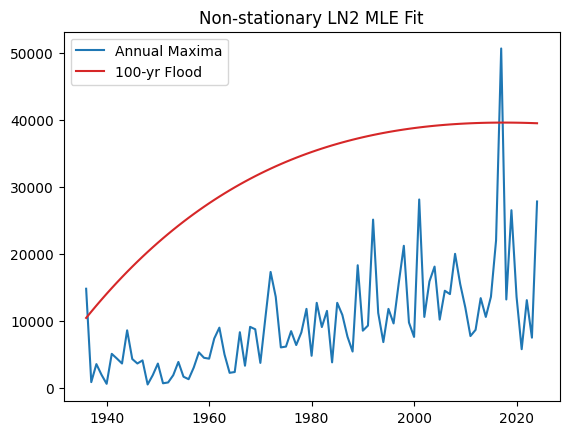

Return period of largest flood under non-stationary LN3 MLE fit: 1120 year


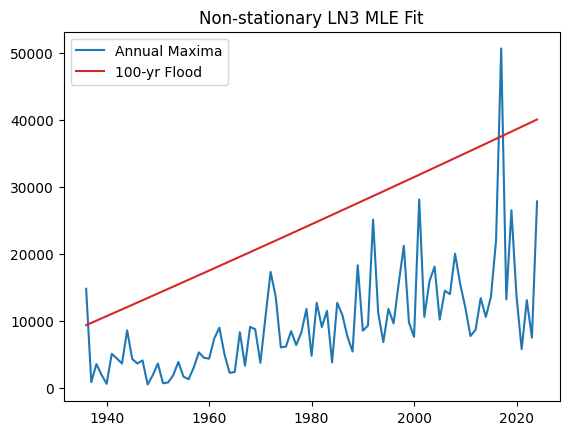

In [23]:
for npar in npars:
  distfit = LogNormal()
  distfit.NSfit(np.array(flow_df["peak_va"]), "MLE", npar, 2)
  mus = distfit.mu
  sigmas = distfit.sigma

  # estimate 100-yr flood each year
  q100s = np.empty(len(flow_df["Year"]))
  for i, year in enumerate(flow_df["Year"]):
    distfit.mu = mus[i]
    distfit.sigma = sigmas[i]
    q100s[i] = distfit.findReturnPd(100)

  # estimate the return period of the largest flood in the year it happened
  # based on the non-stationary fit
  index = np.argmax(flow_df["peak_va"])
  Tmax = 1/(1 - ss.lognorm.cdf(np.max(flow_df["peak_va"]), distfit.sigma, distfit.tau, np.exp(mus[index])))
  print("Return period of largest flood under non-stationary LN%d MLE fit: %0.0f year" % (npar, Tmax))

  l1, = plt.plot(flow_df["Year"], flow_df["peak_va"], color='tab:blue')
  l2, = plt.plot(flow_df["Year"], q100s, color="tab:red")
  plt.title("Non-stationary LN" + str(npar) + " MLE Fit")
  plt.legend([l1,l2],['Annual Maxima','100-yr Flood'])
  plt.show()

## Finally, assume the scale, shape, and location parameters are changing linearly with time.

Return period of largest flood under non-stationary LN3 MLE fit: 178 year


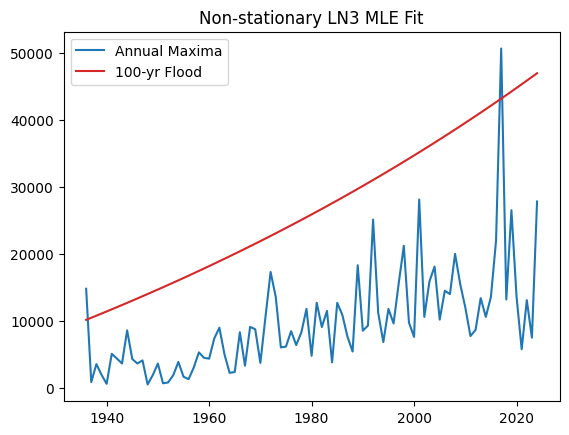

In [24]:
distfit = LogNormal()
distfit.NSfit(np.array(flow_df["peak_va"]), "MLE", 3, 3)
mus = distfit.mu
sigmas = distfit.sigma
taus = distfit.tau

# estimate 100-yr flood each year
q100s = np.empty(len(flow_df["Year"]))
for i, year in enumerate(flow_df["Year"]):
  distfit.mu = mus[i]
  distfit.sigma = sigmas[i]
  distfit.tau = taus[i]
  q100s[i] = distfit.findReturnPd(100)

# estimate the return period of the largest flood in the year it happened
# based on the non-stationary fit
index = np.argmax(flow_df["peak_va"])
Tmax = 1/(1 - ss.lognorm.cdf(np.max(flow_df["peak_va"]), distfit.sigma, distfit.tau, np.exp(mus[index])))
print("Return period of largest flood under non-stationary LN%d MLE fit: %0.0f year" % (npar, Tmax))

l1, = plt.plot(flow_df["Year"], flow_df["peak_va"], color='tab:blue')
l2, = plt.plot(flow_df["Year"], q100s, color="tab:red")
plt.title("Non-stationary LN" + str(npar) + " MLE Fit")
plt.legend([l1,l2],['Annual Maxima','100-yr Flood'])
plt.show()

Across all these approaches, we've gotten vastly different 100-yr flood estimates! This illustrates the greater uncertainty associated with non-stationary flood frequency analysis, highlighting the tradeoff between bias and variance.